In [ ]:
!kaggle datasets download -d vitngquang/uit-viic-v1-0-vietnamese-image-captioning

Dataset URL: https://www.kaggle.com/datasets/vitngquang/uit-viic-v1-0-vietnamese-image-captioning
License(s): other
100% 1.23G/1.23G [00:41<00:00, 27.1MB/s]
100% 1.23G/1.23G [00:41<00:00, 32.1MB/s]


In [ ]:
!unzip -q uit-viic-v1-0-vietnamese-image-captioning.zip

# Thư viện

In [ ]:
!pip install peft

In [ ]:
!pip install bitsandbytes==0.44.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 7.4 MB/s eta 0:00:00


In [ ]:
!pip install pyvi

In [ ]:
!pip install datasets

In [ ]:
import pandas as pd
from PIL import Image
from transformers import Blip2ForConditionalGeneration, Blip2Processor, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model
import torch
from datasets import Dataset

# Load mô hình (int8) và convert sang PEFT

In [ ]:
quant_config = BitsAndBytesConfig(load_in_8bit=True)

processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("ybelkada/blip2-opt-2.7b-fp16-sharded", device_map="auto", quantization_config=quant_config)

In [ ]:
config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["q_proj", "k_proj"]
)

model = get_peft_model(model, config)
model.print_trainable_parameters()

In [ ]:
class ImageCaptioningDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding["caption"] = item["caption"]
        return encoding

def collate_fn(batch):
    # pad the input_ids and attention_mask
    processed_batch = {}
    for key in batch[0].keys():
        if key != "caption":
            processed_batch[key] = torch.stack([example[key] for example in batch])
        else:
            text_inputs = processor.tokenizer(
                [example["caption"] for example in batch], padding=True, return_tensors="pt"
            )
            processed_batch["input_ids"] = text_inputs["input_ids"]
            processed_batch["attention_mask"] = text_inputs["attention_mask"]
    return processed_batch

# Xử lý dữ liệu

In [ ]:
dataset_path = '/content/dataset'

In [ ]:
def load_data(path):
    with open(path + 'captions.txt', 'r', encoding='utf-8') as file:
        lines = file.readlines()

    data = [line.split('\t', 1) for line in lines]
    df = pd.DataFrame(data, columns=["image_path", "caption"])

    return df

In [ ]:
train_path = dataset_path + '/train/'
val_path = dataset_path + '/val/'
test_path = dataset_path + '/test/'

df_train = load_data(train_path)
df_val = load_data(val_path)
df_test = load_data(test_path)

In [ ]:
from pyvi import ViUtils, ViTokenizer

def text_preprocessing(text):
    text = ViTokenizer.tokenize(text)
    text = text.replace('\n', ' ')
    text = ViUtils.remove_accents(text)
    text = text.decode("utf-8")
    text = text.replace("'", "")
    text = text.lstrip('b')
    return text

In [ ]:
df_train['caption'] = df_train['caption'].apply(lambda x: text_preprocessing(x))
df_val['caption'] = df_val['caption'].apply(lambda x: text_preprocessing(x))
df_test['caption'] = df_test['caption'].apply(lambda x: text_preprocessing(x))

In [ ]:
train_dataset = Dataset.from_pandas(df_train)
val_dataset = Dataset.from_pandas(df_val)
test_dataset = Dataset.from_pandas(df_test)

In [ ]:
dataset_path_2 = '/content'

def load_image(image_path):
  image_path = dataset_path_2 + image_path
  return Image.open(image_path)

In [ ]:
train_dataset = train_dataset.map(lambda example: {"image": load_image(example["image_path"])}, batched=False)

Map:   0%|          | 0/13481 [00:00<?, ? examples/s]

In [ ]:
train_dataset = train_dataset.remove_columns(["image_path"])

In [ ]:
val_dataset = val_dataset.map(lambda example: {"image": load_image(example["image_path"])}, batched=False)
val_dataset = val_dataset.remove_columns(["image_path"])

Map:   0%|          | 0/4620 [00:00<?, ? examples/s]

In [ ]:
train_dataset = ImageCaptioningDataset(train_dataset, processor)
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=3, collate_fn=collate_fn)

In [ ]:
val_dataset = ImageCaptioningDataset(val_dataset, processor)
val_dataloader = torch.utils.data.DataLoader(val_dataset, shuffle=True, batch_size=3, collate_fn=collate_fn)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
import torch
from tqdm import tqdm

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

device = "cuda" if torch.cuda.is_available() else "cpu"

best_val_loss = float('inf')
best_model_path = "best_model.pth"
epochs_no_improve = 0
n_epochs_stop = 2
max_epochs = 30

for epoch in range(max_epochs):
    print(f"Epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_train_loss = 0
    with tqdm(train_dataloader, desc=f"Epoch {epoch + 1} (Train)", unit="batch") as tepoch:
        for idx, batch in enumerate(tepoch):
            input_ids = batch.pop("input_ids").to(device)
            # Chuyển pixel_values sang kiểu dữ liệu phù hợp với device và model (float32)
            pixel_values = batch.pop("pixel_values").to(device, dtype=torch.float32)

            outputs = model(input_ids=input_ids,
                            pixel_values=pixel_values,
                            labels=input_ids)

            loss = outputs.loss
            epoch_train_loss += loss.item()

            tepoch.set_postfix(loss=loss.item())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

    avg_train_loss = epoch_train_loss / len(train_dataloader)
    print(f"Average training loss for epoch {epoch + 1}: {avg_train_loss:.4f}")

    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        with tqdm(val_dataloader, desc=f"Epoch {epoch + 1} (Val)", unit="batch") as vepoch:
            for idx, batch in enumerate(vepoch):
                input_ids = batch.pop("input_ids").to(device)
                pixel_values = batch.pop("pixel_values").to(device, dtype=torch.float32)

                outputs = model(input_ids=input_ids,
                                pixel_values=pixel_values,
                                labels=input_ids)

                loss = outputs.loss
                epoch_val_loss += loss.item()

                vepoch.set_postfix(loss=loss.item())

    avg_val_loss = epoch_val_loss / len(val_dataloader)
    print(f"Average validation loss for epoch {epoch + 1}: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Model saved to {best_model_path} with validation loss: {best_val_loss:.4f}")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"Validation loss did not improve for {epochs_no_improve} epochs.")

    if epochs_no_improve == n_epochs_stop:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

print("Training finished.")

Epoch 1/10


Epoch 1 (Train): 100%|██████████| 4494/4494 [46:33<00:00,  1.61batch/s, loss=0.87]


Average training loss for epoch 1: 1.2317


Epoch 1 (Val): 100%|██████████| 1540/1540 [11:31<00:00,  2.23batch/s, loss=0.562]


Average validation loss for epoch 1: 1.0427
Model saved to best_model.pth with validation loss: 1.0427
Epoch 2/10


Epoch 2 (Train): 100%|██████████| 4494/4494 [46:14<00:00,  1.62batch/s, loss=1.31]


Average training loss for epoch 2: 1.6037


Epoch 2 (Val): 100%|██████████| 1540/1540 [11:26<00:00,  2.24batch/s, loss=2.44]


Average validation loss for epoch 2: 2.3728
Validation loss did not improve for 1 epochs.
Epoch 3/10


Epoch 3 (Train): 100%|██████████| 4494/4494 [46:20<00:00,  1.62batch/s, loss=3.56]


Average training loss for epoch 3: 3.2042


Epoch 3 (Val): 100%|██████████| 1540/1540 [11:29<00:00,  2.23batch/s, loss=3.86]

Average validation loss for epoch 3: 3.7734
Validation loss did not improve for 2 epochs.
Early stopping triggered after 3 epochs.
Training finished.


In [ ]:
test_dataset = Dataset.from_pandas(df_test)
test_dataset = test_dataset.map(lambda example: {"image": load_image(example["image_path"])}, batched=False)

Map:   0%|          | 0/1155 [00:00<?, ? examples/s]

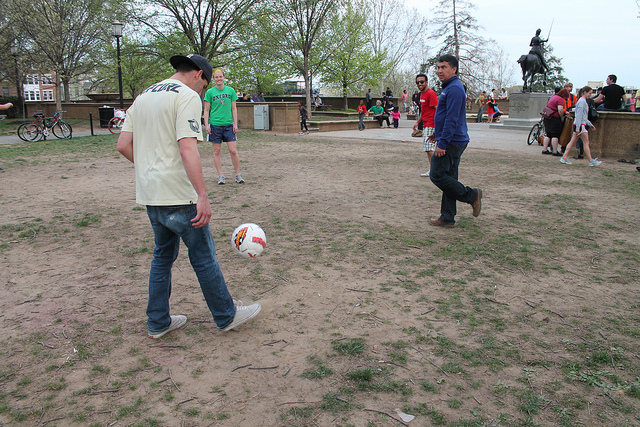

In [ ]:
example = test_dataset[110]
image = example["image"]
image

In [ ]:
!cp /content/kaggle.json /root/.config/kaggle/

In [ ]:
!chmod 600 /root/.config/kaggle/kaggle.json

In [ ]:
!kaggle kernels output kdoobara/fine-tuning-blip-2-peft -p /content

Output file downloaded to /content/best_model.pth
Kernel log downloaded to /content/fine-tuning-blip-2-peft.log 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from peft import PeftModel, LoraConfig, get_peft_model
from transformers import Blip2ForConditionalGeneration, Blip2Processor, BitsAndBytesConfig

# Đường dẫn đến file .pth chứa trọng số của toàn bộ mô hình
checkpoint_path = "/content/best_model.pth"

# Load checkpoint vào model
model.load_state_dict(torch.load(checkpoint_path, map_location="cuda:0")) # Load toàn bộ state_dict

<ipython-input-23-9bc8d0dd925b>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location="cuda:0")) # Load toàn bộ sta

<All keys matched successfully>

# Đánh giá mô hình

In [ ]:
df_test

,image_path,caption
0,/dataset/test/images/000000205086.jpg,Một cậu bé đang chống đẩy trên quả banh.\n
1,/dataset/test/images/000000205086.jpg,Một cậu bé đang chống đầu lên quả bóng đá hít ...
2,/dataset/test/images/000000205086.jpg,Một cậu bé đang hít đất đầu trên quả banh trên...
3,/dataset/test/images/000000205086.jpg,Một cậu bé đang hít đất cùng quả bóng và một c...
4,/dataset/test/images/000000205086.jpg,Một cậu bé đang chống đẩy trên một quả bóng đá.\n
...,...,...
1150,/dataset/test/images/000000509030.jpg,Đứa trẻ đang chơi bóng chày ngoài sân .\n
1151,/dataset/test/images/000000554036.jpg,Một cầu thủ bóng chày cầm gậy trên sân bóng ch...
1152,/dataset/test/images/000000014864.jpg,Hai bức ảnh của vận động viên tennis nữ đang d...
1153,/dataset/test/images/000000463758.jpg,Hai bức ảnh của một người đàn ông đang chơi te...


In [ ]:
def text_preprocessing_test(text):
    text = text.replace('\n', ' ')
    return text

In [ ]:
df_test['caption'] = df_test['caption'].apply(lambda x: text_preprocessing_test(x))

In [ ]:
df_test = df_test.groupby('image_path')['caption'].agg(list).reset_index()
df_test.rename(columns={'caption': 'caption'}, inplace=True)

df_test['caption'].iloc[0]

['Ở trên sân , một cầu thủ đánh bóng đang chuẩn bị đánh bóng . ',
 'Ở trên sân , một cầu thủ đánh bóng đang luyện tập . ',
 'Ở trên sân , một cầu thủ đánh bóng đang vung gậy để đánh bóng . ',
 'Ở trên sân , một người đàn ông đang nghiêng người để chuẩn bị đánh quả bóng chày . ',
 'Một người đàn ông đang vung gậy để đánh quả bóng chày . ']

In [ ]:
test_dataset = Dataset.from_pandas(df_test)
test_dataset = test_dataset.map(lambda example: {"image": load_image(example["image_path"])}, batched=False)

Map:   0%|          | 0/231 [00:00<?, ? examples/s]

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
from tqdm import tqdm

for index, record in tqdm(df_test.iterrows(), total=len(df_test), desc="Processing Captions"):
    img = test_dataset[index]['image']
    inputs = processor(images=img, return_tensors="pt").to(device, torch.float16)
    pixel_values = inputs.pixel_values

    generated_ids = model.generate(pixel_values=pixel_values, max_length=25)
    generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    caption = ' '.join(generated_caption.replace('_', ' ').split())
    df_test.loc[index, 'predict'] = caption


Processing Captions: 100%|██████████| 231/231 [21:19<00:00,  5.54s/it]


In [ ]:
df_test

,image_path,caption,predict
0,/dataset/test/images/000000007615.jpg,"[Ở trên sân , một cầu thủ đánh bóng đang chuẩn...",Mot cau thu danh bong dang vung gay de danh bong
1,/dataset/test/images/000000009895.jpg,[Hình ảnh hai cậu bé đang chơi trong khu dân c...,Mot cau be dang luyen tap bong chay o tren san .
2,/dataset/test/images/000000011015.jpg,[Hình ảnh một trận thi đấu bóng đá đang diễn r...,Cac cau thu bong da dang thi dau tren san .
3,/dataset/test/images/000000014864.jpg,[Một người phụ nữ đang vung vợt để đánh quả bó...,Mot nguoi phu nu dang vung vot tennis danh qua...
4,/dataset/test/images/000000014876.jpg,[Một cậu bé đang nghiêng người để đánh quả bón...,Mot cau be dang vung gay de danh qua bong chay .
...,...,...,...
226,/dataset/test/images/000000562596.jpg,[Một người đàn ông đang dùng vợt để đánh quả b...,Mot nguoi dan ong dang chuan bi danh qua bong ...
227,/dataset/test/images/000000564627.jpg,[Một người đàn ông đang chuẩn bị đánh quả bóng...,Mot nguoi dan ong dang vung vot tennis danh tr...
228,/dataset/test/images/000000565360.jpg,[Các cầu thủ bóng đá đang thi đấu ở ngoài trời...,Mot nguoi dan ong dang chuan bi danh qua bong ...
229,/dataset/test/images/000000572998.jpg,[Một cầu thủ đánh bóng đang xoay người để đánh...,Cau thu bong chay dang thi dau tren san .


In [ ]:
df_test[['image_path', 'predict']].to_csv('output.txt', sep='\t', header=False, index=False)

In [ ]:
data = []
with open("blip_2_vn.txt", "r") as f:
    for line in f:
        parts = line.strip().split(" ", 1)
        data.append(parts)

df_test_blip_2 = pd.DataFrame(data, columns=["image_path", "description"])

In [ ]:
df_test_blip_2

,image_path,description
0,/dataset/test/images/000000007615.jpg,Một cầu thủ đánh bóng đang vung gậy để đánh bóng
1,/dataset/test/images/000000009895.jpg,Một cậu bé đang luyện tập bóng chày ở trên sân.
2,/dataset/test/images/000000011015.jpg,Các cầu thủ bóng đá đang thi đấu trên sân.
3,/dataset/test/images/000000014864.jpg,Một người phụ nữ đang vung vợt tennis đánh quả...
4,/dataset/test/images/000000014876.jpg,Một cậu bé đang vung gậy để đánh quả bóng chày.
...,...,...
226,/dataset/test/images/000000562596.jpg,Một người đàn ông đang chuẩn bị đánh quả bóng ...
227,/dataset/test/images/000000564627.jpg,Một người đàn ông đang vung vợt tennis đánh tr...
228,/dataset/test/images/000000565360.jpg,Một người đàn ông đang chuẩn bị đánh quả bóng
229,/dataset/test/images/000000572998.jpg,Cầu thủ bóng chày đang thi đấu trên sân.


In [ ]:
df_test['predict'] = df_test_blip_2['description']

In [ ]:
df_test['predict'] = df_test['predict'].str.lower()

In [ ]:
df_test['caption'] = df_test['caption'].apply(lambda x: [s.lower() for s in x])

In [ ]:
df_test

,image_path,caption,predict
0,/dataset/test/images/000000007615.jpg,"[ở trên sân , một cầu thủ đánh bóng đang chuẩn...",một cầu thủ đánh bóng đang vung gậy để đánh bóng
1,/dataset/test/images/000000009895.jpg,[hình ảnh hai cậu bé đang chơi trong khu dân c...,một cậu bé đang luyện tập bóng chày ở trên sân.
2,/dataset/test/images/000000011015.jpg,[hình ảnh một trận thi đấu bóng đá đang diễn r...,các cầu thủ bóng đá đang thi đấu trên sân.
3,/dataset/test/images/000000014864.jpg,[một người phụ nữ đang vung vợt để đánh quả bó...,một người phụ nữ đang vung vợt tennis đánh quả...
4,/dataset/test/images/000000014876.jpg,[một cậu bé đang nghiêng người để đánh quả bón...,một cậu bé đang vung gậy để đánh quả bóng chày.
...,...,...,...
226,/dataset/test/images/000000562596.jpg,[một người đàn ông đang dùng vợt để đánh quả b...,một người đàn ông đang chuẩn bị đánh quả bóng ...
227,/dataset/test/images/000000564627.jpg,[một người đàn ông đang chuẩn bị đánh quả bóng...,một người đàn ông đang vung vợt tennis đánh tr...
228,/dataset/test/images/000000565360.jpg,[các cầu thủ bóng đá đang thi đấu ở ngoài trời...,một người đàn ông đang chuẩn bị đánh quả bóng
229,/dataset/test/images/000000572998.jpg,[một cầu thủ đánh bóng đang xoay người để đánh...,cầu thủ bóng chày đang thi đấu trên sân.


## BLEU

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

In [ ]:
def calculate_bleu_scores(row):
    reference = [caption.split() for caption in row['caption']]
    prediction = row['predict'].split()

    smoothie = SmoothingFunction().method4

    bleu_1 = sentence_bleu(reference, prediction, weights=(1.0, 0, 0, 0), smoothing_function=smoothie)
    bleu_2 = sentence_bleu(reference, prediction, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie)
    bleu_3 = sentence_bleu(reference, prediction, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie)
    bleu_4 = sentence_bleu(reference, prediction, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)

    return pd.Series([bleu_1, bleu_2, bleu_3, bleu_4])

In [ ]:
df_test[['bleu_1', 'bleu_2', 'bleu_3', 'bleu_4']] = df_test.apply(calculate_bleu_scores, axis=1)

In [ ]:
df_test

,image_path,caption,predict,bleu_1,bleu_2,bleu_3,bleu_4
0,/dataset/test/images/000000007615.jpg,"[ở trên sân , một cầu thủ đánh bóng đang chuẩn...",một cầu thủ đánh bóng đang vung gậy để đánh bóng,0.833753,0.833753,0.833753,0.833753
1,/dataset/test/images/000000009895.jpg,[hình ảnh hai cậu bé đang chơi trong khu dân c...,một cậu bé đang luyện tập bóng chày ở trên sân.,0.830092,0.674370,0.572043,0.453052
2,/dataset/test/images/000000011015.jpg,[hình ảnh một trận thi đấu bóng đá đang diễn r...,các cầu thủ bóng đá đang thi đấu trên sân.,0.900000,0.774597,0.672125,0.598806
3,/dataset/test/images/000000014864.jpg,[một người phụ nữ đang vung vợt để đánh quả bó...,một người phụ nữ đang vung vợt tennis đánh quả...,0.916667,0.816497,0.739060,0.649336
4,/dataset/test/images/000000014876.jpg,[một cậu bé đang nghiêng người để đánh quả bón...,một cậu bé đang vung gậy để đánh quả bóng chày.,0.830092,0.778695,0.719066,0.640712
...,...,...,...,...,...,...,...
226,/dataset/test/images/000000562596.jpg,[một người đàn ông đang dùng vợt để đánh quả b...,một người đàn ông đang chuẩn bị đánh quả bóng ...,0.664073,0.603174,0.531433,0.428470
227,/dataset/test/images/000000564627.jpg,[một người đàn ông đang chuẩn bị đánh quả bóng...,một người đàn ông đang vung vợt tennis đánh tr...,0.747082,0.639763,0.594715,0.554873
228,/dataset/test/images/000000565360.jpg,[các cầu thủ bóng đá đang thi đấu ở ngoài trời...,một người đàn ông đang chuẩn bị đánh quả bóng,0.409365,0.334245,0.286861,0.227412
229,/dataset/test/images/000000572998.jpg,[một cầu thủ đánh bóng đang xoay người để đánh...,cầu thủ bóng chày đang thi đấu trên sân.,0.398073,0.267035,0.119193,0.067728


In [ ]:
bleu_1_avg = round(df_test['bleu_1'].mean() * 100, 2)
bleu_2_avg = round(df_test['bleu_2'].mean() * 100, 2)
bleu_3_avg = round(df_test['bleu_3'].mean() * 100, 2)
bleu_4_avg = round(df_test['bleu_4'].mean() * 100, 2)

# In kết quả BLEU score trung bình
print("Average BLEU-1 Score:", bleu_1_avg)
print("Average BLEU-2 Score:", bleu_2_avg)
print("Average BLEU-3 Score:", bleu_3_avg)
print("Average BLEU-4 Score:", bleu_4_avg)

Average BLEU-1 Score: 57.97
Average BLEU-2 Score: 45.2
Average BLEU-3 Score: 36.91
Average BLEU-4 Score: 30.12


In [ ]:
bleu_1_avg = round(df_test['bleu_1'].mean() * 100, 2)
bleu_2_avg = round(df_test['bleu_2'].mean() * 100, 2)
bleu_3_avg = round(df_test['bleu_3'].mean() * 100, 2)
bleu_4_avg = round(df_test['bleu_4'].mean() * 100, 2)

# In kết quả BLEU score trung bình
print("Average BLEU-1 Score:", bleu_1_avg)
print("Average BLEU-2 Score:", bleu_2_avg)
print("Average BLEU-3 Score:", bleu_3_avg)
print("Average BLEU-4 Score:", bleu_4_avg)

Average BLEU-1 Score: 53.78
Average BLEU-2 Score: 43.2
Average BLEU-3 Score: 35.9
Average BLEU-4 Score: 29.47


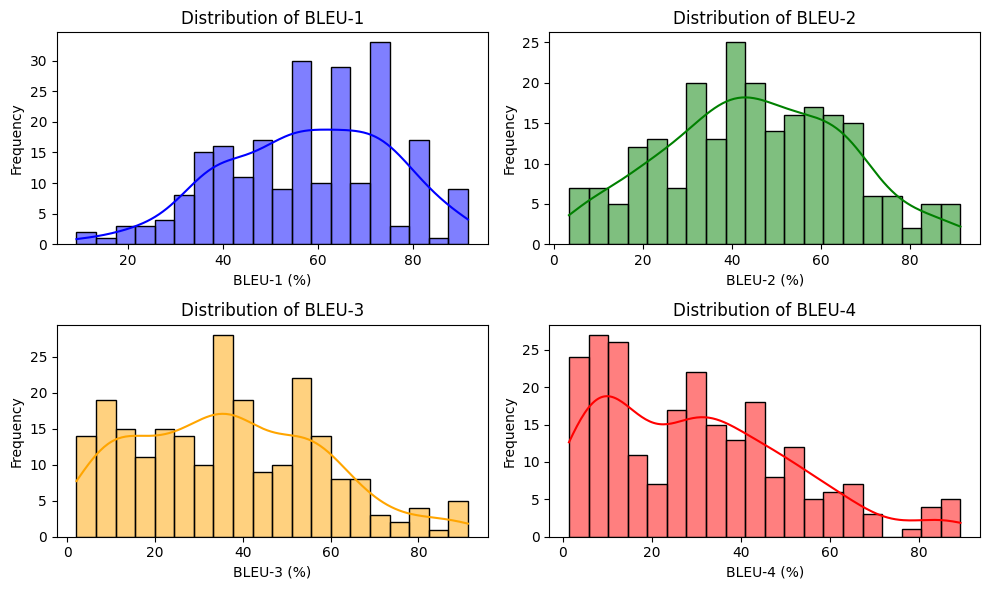

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
sns.histplot(df_test['bleu_1'] * 100, kde=True, bins=20, color='blue', label='BLEU-1')
plt.title('Distribution of BLEU-1')
plt.xlabel('BLEU-1 (%)')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
sns.histplot(df_test['bleu_2'] * 100, kde=True, bins=20, color='green', label='BLEU-2')
plt.title('Distribution of BLEU-2')
plt.xlabel('BLEU-2 (%)')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
sns.histplot(df_test['bleu_3'] * 100, kde=True, bins=20, color='orange', label='BLEU-3')
plt.title('Distribution of BLEU-3')
plt.xlabel('BLEU-3 (%)')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
sns.histplot(df_test['bleu_4'] * 100, kde=True, bins=20, color='red', label='BLEU-4')
plt.title('Distribution of BLEU-4')
plt.xlabel('BLEU-4 (%)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


## ROUGE-L

In [ ]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=c6a80c43e01e93db95e67221696d0742dcabf9d66ee9017242e08fffe49a9fdd
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
from rouge_score import rouge_scorer

In [ ]:
def calculate_rouge_scores(row):
    reference = row['caption']
    prediction = row['predict']

    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    total_f1 = 0

    for ref in reference:
        scores = scorer.score(ref, prediction)
        rouge_l = scores['rougeL']
        total_f1 += rouge_l.fmeasure

    avg_f1 = total_f1 / len(reference)

    return avg_f1

In [ ]:
df_test['rouge_L'] = df_test.apply(calculate_rouge_scores, axis=1)

In [ ]:
df_test

,image_path,caption,predict,bleu_1,bleu_2,bleu_3,bleu_4,rouge_L
0,/dataset/test/images/000000007615.jpg,"[ở trên sân , một cầu thủ đánh bóng đang chuẩn...",một cầu thủ đánh bóng đang vung gậy để đánh bóng,0.833753,0.833753,0.833753,0.833753,0.630974
1,/dataset/test/images/000000009895.jpg,[hình ảnh hai cậu bé đang chơi trong khu dân c...,một cậu bé đang luyện tập bóng chày ở trên sân.,0.830092,0.674370,0.572043,0.453052,0.499913
2,/dataset/test/images/000000011015.jpg,[hình ảnh một trận thi đấu bóng đá đang diễn r...,các cầu thủ bóng đá đang thi đấu trên sân.,0.900000,0.774597,0.672125,0.598806,0.516755
3,/dataset/test/images/000000014864.jpg,[một người phụ nữ đang vung vợt để đánh quả bó...,một người phụ nữ đang vung vợt tennis đánh quả...,0.916667,0.816497,0.739060,0.649336,0.638665
4,/dataset/test/images/000000014876.jpg,[một cậu bé đang nghiêng người để đánh quả bón...,một cậu bé đang vung gậy để đánh quả bóng chày.,0.830092,0.778695,0.719066,0.640712,0.674618
...,...,...,...,...,...,...,...,...
226,/dataset/test/images/000000562596.jpg,[một người đàn ông đang dùng vợt để đánh quả b...,một người đàn ông đang chuẩn bị đánh quả bóng ...,0.664073,0.603174,0.531433,0.428470,0.743656
227,/dataset/test/images/000000564627.jpg,[một người đàn ông đang chuẩn bị đánh quả bóng...,một người đàn ông đang vung vợt tennis đánh tr...,0.747082,0.639763,0.594715,0.554873,0.703363
228,/dataset/test/images/000000565360.jpg,[các cầu thủ bóng đá đang thi đấu ở ngoài trời...,một người đàn ông đang chuẩn bị đánh quả bóng,0.409365,0.334245,0.286861,0.227412,0.262484
229,/dataset/test/images/000000572998.jpg,[một cầu thủ đánh bóng đang xoay người để đánh...,cầu thủ bóng chày đang thi đấu trên sân.,0.398073,0.267035,0.119193,0.067728,0.338851


In [ ]:
rouge_L_avg = round(df_test['rouge_L'].mean() * 100, 2)
print("Average ROUGE-L Score:", rouge_L_avg)

Average ROUGE-L Score: 48.06
